## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from variaIa import tools
from importlib import reload
from pymage import panstarrs
from pshost import massmeasure
from variaIa import stretchevol
from variaIa.tools import surveys, df_cons, df_nc, df_c, df_full, z_max
from IPython.display import display, HTML, Latex
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import random

display(HTML("<style>.container { width:100% !important; }</style>"))

### Définition des données à montrer

In [2]:
btw = ipw.Checkbox(
    value=False,
    description='btw')
after = ipw.Checkbox(
    value=False,
    description='After')

def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=tools.cons, su=tools.su)
display(ipw.HBox([int_set_su, btw, after]))

smap = plt.cm.get_cmap('cividis')
colors = {'SNF': plt.cm.binary(0.9),
          'low-z': (1, 0, 0),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300)}  # for viridis
          'All': (255/255, 51/255, 0/255)}

def alphacolors(alpha, survey):
    return(colors[survey][0], colors[survey][1], colors[survey][2], alpha)

df_nHST = df_nc[df_nc['survey'] != 'HST']

## Low-z ra, dec and zcmb to extract

In [3]:
d = pd.read_csv('../../../Data/data_cheat.csv', sep=' ')#, index_col='CID')
todl = d[d['IDSURVEY'].isin([5, 61, 62, 63, 64, 65, 66])][['CID', 'RA', 'DECL', 'zCMB']].values
# Indexes 131 and 142 couldn't be recovered with PS1Target
ra = np.concatenate((todl[:, 1][:131], todl[:, 1][132:142],
                    todl[:, 1][143:]), axis=None)
dec = np.concatenate((todl[:, 2][:131], todl[:, 2][132:142],
                    todl[:, 2][143:]), axis=None)
zcmb = np.concatenate((todl[:, 3][:131], todl[:, 3][132:142],
                    todl[:, 3][143:]), axis=None)

#pscls = []
for i in range(143, len(ra)):
    pscls.append(panstarrs.PS1Target.from_coord(ra[i], dec[i]))
    pscls[-1].download_cutout(load_weight=True)

In [71]:
with open('../../../Data/pscls', 'rb') as f:
    pscls = pickle.load(f)

lowz_mass = []
for i in range(len(ra)):
    mm = massmeasure.MassMeasure(ra[i], dec[i], zcmb[i], pscls[i].imgcutout)
    lowz_mass.append(mm.get_hostgalaxy_params())

pickle.dump(lowz_mass, open('../../../Data/lowz_mass', 'wb'))

In [4]:
with open('../../../Data/lowz_mass', 'rb') as f:
    lowz_mass = pickle.load(f)

In [92]:
i = 2
mm = massmeasure.MassMeasure(ra[i], dec[i], zcmb[i], pscls[i].imgcutout)
mm.get_hostgalaxy_params()

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/astrobject-0.8.6-py3.7.egg/astrobject/photometry.py:1352: UserWarning: Automatic Threshold lowered for too few sources has been detected 


(10.94831425523576, 0.09698252954691178, 0.10091832500778253)

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/astrobject-0.8.6-py3.7.egg/astrobject/utils/mpladdon.py:731: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


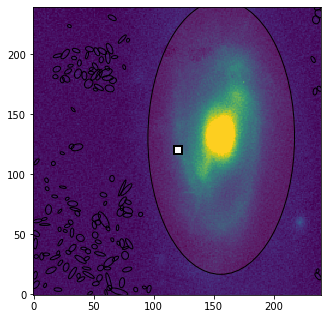

<Figure size 360x360 with 0 Axes>

In [93]:
fig = plt.figure(figsize=[5, 5])
ax = fig.add_axes([0.12, 0.12, 0.8, 0.8])

mm.show(ax=ax, band='r', ellipse=True, ell_color=(1, 0, 0, 0.1))
#hg_patch = Ellipse([hg_ell_test[0], hg_ell_test[1]],
#                   hg_ell_test[2]*4, hg_ell_test[3]*4,
#                   hg_ell_test[4], color='green')
#ax.add_patch(hg_patch)
fig.savefig(f'../../../Images/pdf/mass_cutout_size_{i}.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/mass_cutout_size_{i}.png', bbox_inches='tight', dpi=600)

In [67]:
from astrobject.catalogue import catalogues

In [68]:
catalogues.fetch_panstarrs_catalogue('7.46175 31.392744', '1d')

IndexError: No table found in VOTABLE file.

## `low-z` measured vs PS1 mass histogram

### Find closest PS1 catalog entry

In [32]:
p = panstarrs.PS1Target.from_coord(ra[i], dec[i])
p.download_catalog()

In [58]:
print(ra[i], dec[i])

7.46175 31.392744


In [60]:
p.catdata.columns

Index(['objInfoFlag', 'objID', 'objName', 'qualityFlag', 'raStack', 'decStack',
       'raStackErr', 'decStackErr', 'raMean', 'decMean', 'raMeanErr',
       'decMeanErr', 'ng', 'nr', 'ni', 'nz', 'ny', 'gPSFMag', 'rPSFMag',
       'iPSFMag', 'zPSFMag', 'yPSFMag', 'gPSFMagErr', 'rPSFMagErr',
       'iPSFMagErr', 'zPSFMagErr', 'yPSFMagErr', 'gKronMag', 'rKronMag',
       'iKronMag', 'zKronMag', 'yKronMag', 'gKronMagErr', 'rKronMagErr',
       'iKronMagErr', 'zKronMagErr', 'yKronMagErr', 'gApMag', 'rApMag',
       'iApMag', 'zApMag', 'yApMag', 'gApMagErr', 'rApMagErr', 'iApMagErr',
       'zApMagErr', 'yApMagErr'],
      dtype='object')

In [57]:
p.catdata[['raStack', 'decStack']]
#ra_ps1 = p.catdata['raStack']
#ra_ps1 = p.catdata['raStack']

,raStack,decStack
0,7.460332,31.373448
1,7.466094,31.373669
2,7.457578,31.375728
3,7.460827,31.379316
4,7.462478,31.381903
5,7.462802,31.377259
6,7.467925,31.376501
7,7.440187,31.387133
8,7.443189,31.386263
9,7.443393,31.384788


## Hist

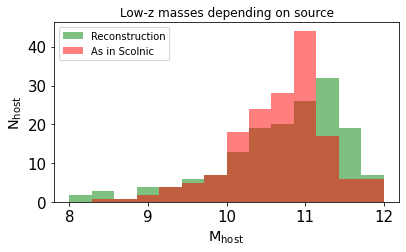

In [15]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

nb_bins = 14

where = np.where(lowz_mass[:, 0] > 8)

#h, r = np.histogram(lowz_mass[:, 0][where],
#                    range=[8, 12], bins=nb_bins)
#xbin = np.mean([r[:-1], r[1:]], axis=0)

ax.hist(lowz_mass[:, 0][where],
        range=[8, 12], bins=nb_bins,
        color='g', alpha=.5,
        label='Reconstruction')
        
#ax.errorbar(xbin, h, yerr=np.array(
#    [lowz_mass[i][1:] for i in range(len(h))]).T,
#            marker="None", ls="None",
#            lw=1, alpha=.5,
#            ecolor='g')

ax.hist(df.hostmass[df.hostmass > 8],
        range=[8,12], bins=nb_bins,
        color=colors['low-z'], alpha=.5,
        label='As in Scolnic')

ax.tick_params(labelsize=15)

ax.set_xlabel(r"$\mathrm{M}_\mathrm{host}$", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{N}_\mathrm{host}$", fontsize="x-large")

ax.legend()

plt.title('Low-z masses depending on source')

fig.savefig('../../../Images/pdf/lowz_comp_hist.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/lowz_comp_hist.png', bbox_inches='tight', dpi=600)

## Scatter

In [49]:
np.shape(x_err)

(2, 163)

No handles with labels found to put in legend.


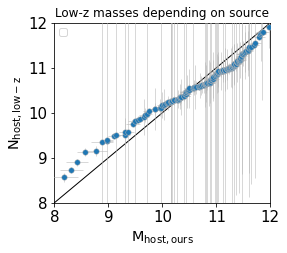

In [64]:
fig = plt.figure(figsize=[5, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

sort_recons = np.argsort(lowz_mass[:,0])
lowz_mass_sorted = lowz_mass[sort_recons]
select_recons = np.where(lowz_mass_sorted[:,0] > 8)
x_val = lowz_mass_sorted[:,0][select_recons][1:]
x_err = np.array([lowz_mass_sorted[i,1:] for i in range(len(x_val))]).T

sort_sco = np.argsort(df.hostmass.values)
sco_mass_sorted = df.hostmass.values[sort_sco]
select_sco = np.where(sco_mass_sorted > 8)
y_val = sco_mass_sorted[select_sco]
sco_masserr_sorted = df.hostmass_err.values[sort_sco]
y_err = sco_masserr_sorted[select_sco]

#ax.scatter(np.sort(np.concatenate((lowz_mass[:, 0], [5.0, 5.0]))),#[where],
#           np.sort(df.hostmass))

ax.scatter(x_val, y_val,
           marker='o', s=30,
           linewidths=.5,
           edgecolors='0.7',
           zorder=7)

ax.errorbar(x_val, y_val,
            xerr=x_err, yerr=y_err,
            ecolor='0.7', alpha=1, ms=0,
            lw=.5, ls='none', label=None, zorder=5)

ax.plot([8, 12], [8, 12], lw=1, color='k', zorder=1)

ax.tick_params(labelsize=15)

ax.set_xlim(8, 12)
ax.set_ylim(8, 12)

ax.set_xlabel(r"$\mathrm{M}_\mathrm{host, ours}$", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{N}_\mathrm{host, low-z}$", fontsize="x-large")

ax.legend()

plt.title('Low-z masses depending on source')

fig.savefig('../../../Images/pdf/lowz_comp_scatter.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/lowz_comp_scatter.png', bbox_inches='tight', dpi=600)

In [69]:
np.unique(list(d[d['IDSURVEY'].isin([5, 61, 62, 63, 64, 65, 66])].HOST_LOGMASS_ERR > 1),
          return_counts=True)

(array([False,  True]), array([126,  46]))